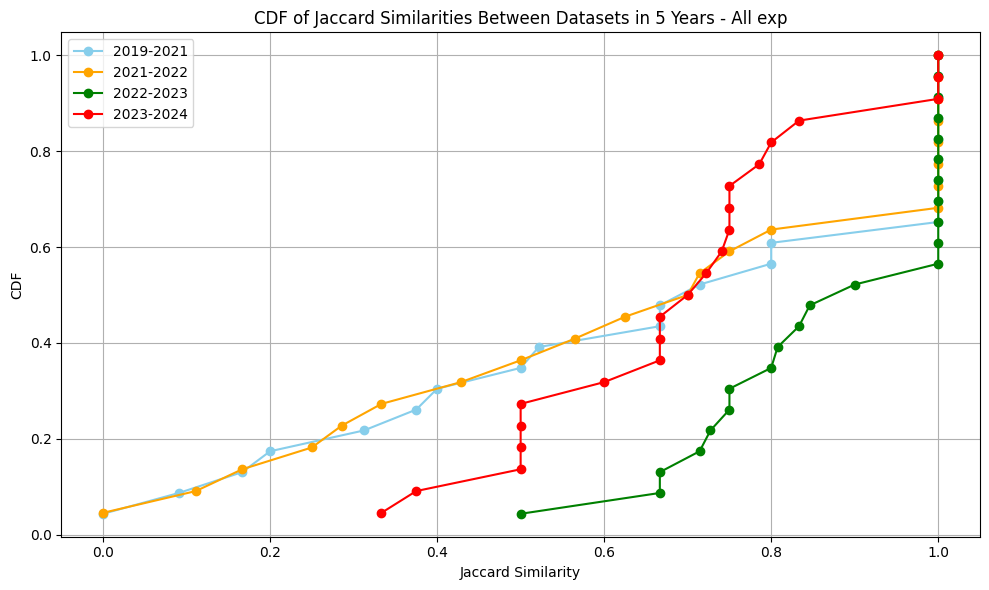

In [6]:
import os
import concurrent.futures
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from collections import defaultdict


def process_domain_list(data_file:str)->dict[str:set]:
    # device_unique_counts = []
    with open(data_file, 'r') as f:
        device_unique_counts = json.load(f)
    for device in device_unique_counts:
        device_unique_counts[device] = set(device_unique_counts[device])
    return device_unique_counts

def calculate_jaccard_similarities(unique_counts_1, unique_counts_2):
    device_jaccard_scores = {}
    gained_domains_1 = {}
    gained_domains_2 = {}
    
    # Calculate the Jaccard similarity and find gained domains
    for device in unique_counts_1:
        if device in unique_counts_2:
            domains_1 = unique_counts_1[device]
            domains_2 = unique_counts_2[device]
            intersection = domains_1.intersection(domains_2)
            union = domains_1.union(domains_2)
            jaccard_similarity = len(intersection) / len(union) if union else 1
            device_jaccard_scores[device] = jaccard_similarity
            gained_domains_1[device] = list(domains_1 - domains_2)
            gained_domains_2[device] = list(domains_2 - domains_1)  # Domains gained in dataset 2
    
    return device_jaccard_scores, gained_domains_1, gained_domains_2

def plot_cdf(device_jaccard_scores):
    # Extract Jaccard similarities for plotting
    similarities = sorted(device_jaccard_scores.values())
    
    # Calculate CDF values
    num_devices = len(similarities)
    cdf_values = np.arange(1, num_devices + 1) / num_devices
    
    # Plot CDF
    plt.figure(figsize=(10, 6))
    plt.plot(similarities, cdf_values, marker='o', linestyle='-', color='skyblue')
    plt.xlabel('Jaccard Similarity')
    plt.ylabel('CDF')
    plt.title('CDF of Jaccard Similarities Between Datasets')
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to make room for the plot
    plt.show()

def plot_cdf_multi(device_jaccard_scores_list, labels, output_dir, year):
    
    plt.figure(figsize=(10, 6))
    colors = ['skyblue', 'orange', 'green', 'red', 'purple']
    for device_jaccard_scores, label in zip(device_jaccard_scores_list, labels):
        # Extract Jaccard similarities for plotting
        similarities = sorted(device_jaccard_scores.values())

        # Calculate CDF values
        num_devices = len(similarities)
        cdf_values = np.arange(1, num_devices + 1) / num_devices

        # Plot CDF
        plt.plot(similarities, cdf_values, marker='o', linestyle='-', label=label, color=colors.pop(0))
    
    plt.legend()
    plt.xlabel('Jaccard Similarity')
    plt.ylabel('CDF')
    plt.title('CDF of Jaccard Similarities Between Datasets in ' + year)
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to make room for the plot
    plt.savefig(os.path.join(output_dir, f"{year}_jaccard_cdf.png"))
    
def create_table(device_jaccard_scores):
    table = pd.DataFrame(list(device_jaccard_scores.items()), columns=['Device', 'Jaccard Similarity'])
    return table

def save_gained_domains(table, gained_domains_1, gained_domains_2, output_dir, year, exp1, exp2):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    # save table
    table.to_csv(os.path.join(output_dir, f"{exp1}_to_{exp2}_jaccard.csv"), index=False)
    # Save gained domains for each device
    with open(os.path.join(output_dir, f"{exp1}_gained_to_{exp2}.json"), 'w') as f:
        json.dump(gained_domains_1, f, indent=4)
    
    with open(os.path.join(output_dir, f"{exp2}_gained_to_{exp1}.json"), 'w') as f:
        json.dump(gained_domains_2, f, indent=4)
        

def run(data_file_list_1, data_file_list_2, output_dir, year, exp1, exp2):
    # Process the directories to get total unique destinations per device using multithreading
    device_unique_domain_1 = defaultdict(set)
    device_unique_domain_2 = defaultdict(set)
    for data_file_1 in data_file_list_1:
        for device, domain_set in process_domain_list(data_file_1).items():
            device_unique_domain_1[device].update(domain_set)
    for data_file_2 in data_file_list_2:
        for device, domain_set in process_domain_list(data_file_2).items():
            device_unique_domain_2[device].update(domain_set)

    # Calculate Jaccard similarities between the two datasets and find gained domains
    device_jaccard_scores, gained_domains_1, gained_domains_2 = calculate_jaccard_similarities(device_unique_domain_1, device_unique_domain_2)

    # Print the table of Jaccard similarities
    table = create_table(device_jaccard_scores)
    # print(table)

    # # Plot the CDF of the Jaccard similarities
    # plot_cdf(device_jaccard_scores)

    # Save gained domains for each device
    save_gained_domains(table, gained_domains_1, gained_domains_2, output_dir, year, exp1, exp2)
    return device_jaccard_scores
    
# Example usage
# data_file_1 = "/home/hutr/iot-longitudinal/output_destination/2019idle/domain_list/unique_slds.json"  # Replace with your first dataset directory
# data_file_2 = "/home/hutr/iot-longitudinal/output_destination/2019activity/domain_list/unique_slds.json"  # Replace with your second dataset directory

# input_dir = "/home/hutr/iot-longitudinal/output_destination/all_devices_remove_duplicates"
input_dir = "/home/hutr/iot-longitudinal/output_destination/common_devices"
years = ["2019", "2021", "2022", "2023", "2024"]
# for year in years:
#     output_dir = os.path.join(input_dir, f"{year}_comparison")
#     # idle and activity
#     data_file_1 = os.path.join(input_dir, f"{year}idle", "domain_list/unique_slds.json")
#     data_file_2 = os.path.join(input_dir, f"{year}activity", "domain_list/unique_slds.json")
#     jaccard_1 = run(data_file_1, data_file_2, output_dir, year, "idle", "activity")
#     # idle and power
#     data_file_1 = os.path.join(input_dir, f"{year}idle", "domain_list/unique_slds.json")
#     data_file_2 = os.path.join(input_dir, f"{year}power", "domain_list/unique_slds.json")
#     jaccard_2 = run(data_file_1, data_file_2, output_dir, year, "idle", "power")
#     # activity and power
#     data_file_1 = os.path.join(input_dir, f"{year}activity", "domain_list/unique_slds.json")
#     data_file_2 = os.path.join(input_dir, f"{year}power", "domain_list/unique_slds.json")
#     jaccard_3 = run(data_file_1, data_file_2, output_dir, year, "activity", "power")
#     plot_cdf_multi([jaccard_1, jaccard_2, jaccard_3], ["idle-activity", "idle-power", "activity-power"], output_dir, year)

jaccard_list = []
for n in range(len(years)-1):
    year = years[n]
    compare_year = years[n+1]
    output_dir = os.path.join(input_dir, f"{year}_{compare_year}_comparison")
    data_file_1 = []
    data_file_2 = []
    for exp in ['idle', 'power', 'activity']:
        data_file_1.append(os.path.join(input_dir, f"{year}{exp}", "domain_list/contacted_domains_with_all_dns.json"))
        data_file_2.append(os.path.join(input_dir, f"{compare_year}{exp}", "domain_list/contacted_domains_with_all_dns.json"))
    jaccard = run(data_file_1, data_file_2, output_dir, year, f"{year}", f"{compare_year}")
    jaccard_list.append(jaccard)
plot_cdf_multi(jaccard_list, [f"{year}-{compare_year}" for year, compare_year in zip(years[:-1], years[1:])], input_dir, "5 Years - All exp")

